# Load Forest Cover

In [3]:
import rasterio
import xarray as xr
import numpy as np
import rioxarray

In [4]:
tif_path = "nlcd_tcc_conus_2021_v2021-4.tif"

In [8]:
ds = rioxarray.open_rasterio(tif_path, chunks={"x": 1024, "y": 1024})
#print(ds)

In [7]:
ds

<xarray.DataArray (band: 1, y: 104424, x: 161190)> Size: 17GB
dask.array<open_rasterio-4a6e6ed98e31561c401a0cbd4310aa2a<this-array>, shape=(1, 104424, 161190), dtype=uint8, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 1MB -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
  * y            (y) float64 835kB 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
    spatial_ref  int64 8B 0
Attributes: (12/19)
    AREA_OR_POINT:              Area
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  255
    STATISTICS_HISTOBINVALUES:  5701798027|559014|2486065|4850690|7782065|113...
    STATISTICS_HISTOMAX:        255
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          33.36994708537
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

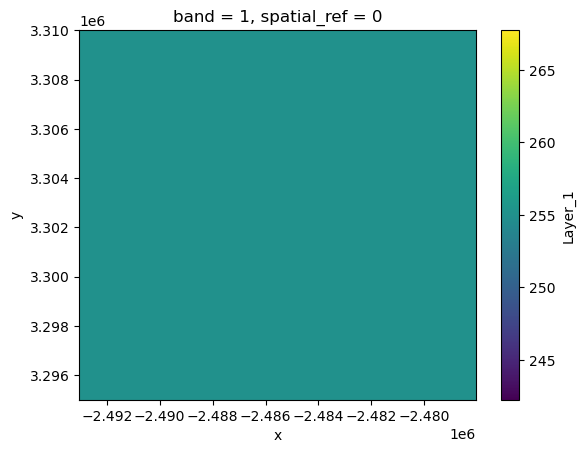

In [9]:
ds.isel(x=slice(0, 500), y=slice(0, 500)).plot()

In [ ]:


# Open the .tif file with rasterio
with rasterio.open(tif_path) as src:
    data = src.read(1)  # read the first band
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height
    bounds = src.bounds

    # Generate coordinate arrays
    x = np.arange(bounds.left + transform.a / 2, bounds.right, transform.a)
    y = np.arange(bounds.top + transform.e / 2, bounds.bottom, transform.e)

    # Flip y if needed so coordinates are ascending
    y = y[::-1] if y[0] > y[-1] else y

    # Create DataArray
    da = xr.DataArray(
        data,
        dims=["y", "x"],
        coords={"y": y, "x": x},
        name="band1",
        attrs={"crs": str(crs)}
    )

# Convert to Dataset if needed
ds = da.to_dataset()
